<a href="https://colab.research.google.com/github/p20230445-bits/crux-inductions-2025/blob/main/notebooks/Task1_KAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

KAN from scratch

In [103]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [104]:
# Spline Function (piecewise linear)
class Spline:
    def __init__(self, num_knots=5):
        self.num_knots = num_knots
        self.knots = np.linspace(0, 1, num_knots)
        self.coeffs = np.random.randn(num_knots) * 0.1  # learnable params

    def forward(self, x):
        # Piecewise linear interpolation
        return np.interp(x, self.knots, self.coeffs)

    def plot(self):
        xs = np.linspace(0, 1, 100)
        ys = [self.forward(x) for x in xs]
        plt.plot(xs, ys, label="Learned Spline")
        plt.scatter(self.knots, self.coeffs, color="red")
        plt.legend()
        plt.show()

In [105]:
# Simple KAN Layer
class KANLayer:
    def __init__(self, input_dim, output_dim, num_knots=5):
        self.splines = [[Spline(num_knots) for _ in range(input_dim)]
                        for _ in range(output_dim)]
        self.bias = np.zeros((1, output_dim))

    def forward(self, X):
        out = []
        for j in range(len(self.splines)):  # for each output neuron
            val = sum(self.splines[j][i].forward(X[:, i])
                      for i in range(len(self.splines[j])))
            out.append(val + self.bias[0, j])
        return np.vstack(out).T  # shape (batch, output_dim)

In [106]:
# KAN Model
class SimpleKAN:
    def __init__(self, input_dim, hidden_dim, output_dim, lr=0.01):
        self.hidden = KANLayer(input_dim, hidden_dim)
        self.out_W = np.random.randn(hidden_dim, output_dim) * 0.1
        self.out_b = np.zeros((1, output_dim))
        self.lr = lr

    def forward(self, X):
        self.z1 = self.hidden.forward(X)
        self.a1 = np.maximum(0, self.z1)  # ReLU
        logits = np.dot(self.a1, self.out_W) + self.out_b
        exp_scores = np.exp(logits - np.max(logits, axis=1, keepdims=True))
        self.a2 = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
        return self.a2

    def compute_loss(self, y_onehot):
        m = y_onehot.shape[0]
        log_likelihood = -np.log(self.a2[range(m), np.argmax(y_onehot, axis=1)])
        return np.sum(log_likelihood) / m

    def train(self, X, y, epochs=100):
        # One-hot encode y
        enc = OneHotEncoder(sparse_output=False)
        y_onehot = enc.fit_transform(y.reshape(-1, 1))
        for epoch in range(epochs):
            probs = self.forward(X)
            loss = self.compute_loss(y_onehot)

            # Gradients for output layer
            dz2 = probs - y_onehot
            dW = np.dot(self.a1.T, dz2) / X.shape[0]
            db = np.sum(dz2, axis=0, keepdims=True) / X.shape[0]

            # Update output layer weights
            self.out_W -= self.lr * dW
            self.out_b -= self.lr * db

            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Loss: {loss:.4f}")

    def predict(self, X):
        probs = self.forward(X)
        return np.argmax(probs, axis=1)


In [107]:
# Load Iris dataset
iris = load_iris()
X, y = iris.data, iris.target
X = (X - X.min()) / (X.max() - X.min())  # normalize to [0,1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [108]:
# Train KAN
kan = SimpleKAN(input_dim=4, hidden_dim=10, output_dim=3, lr=0.1)
kan.train(X_train, y_train, epochs=100)

Epoch 0, Loss: 1.1041
Epoch 10, Loss: 1.0973
Epoch 20, Loss: 1.0909
Epoch 30, Loss: 1.0846
Epoch 40, Loss: 1.0785
Epoch 50, Loss: 1.0725
Epoch 60, Loss: 1.0665
Epoch 70, Loss: 1.0606
Epoch 80, Loss: 1.0548
Epoch 90, Loss: 1.0490


In [109]:
# Evaluate
preds = kan.predict(X_test)
acc = np.mean(preds == y_test)
print(f"Test Accuracy: {acc:.2f}")

Test Accuracy: 0.67


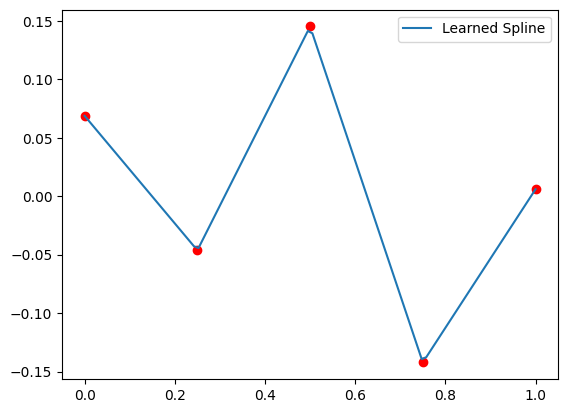

In [110]:
# Plot spline of first hidden neuron, first input
kan.hidden.splines[0][0].plot()

In [111]:
!git clone https://github.com/p20230445-bits/crux-inductions-2025.git
%cd crux-inductions-2025

Cloning into 'crux-inductions-2025'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 59 (delta 14), reused 40 (delta 6), pack-reused 0 (from 0)
Receiving objects: 100% (59/59), 8.46 MiB | 18.95 MiB/s, done.
Resolving deltas: 100% (14/14), done.
/content/pykan/pykan/crux-inductions-2025/pykan/crux-inductions-2025/pykan/crux-inductions-2025


KAN using the pykan library


In [112]:
#Install & Import dependencies
!git clone https://github.com/KindXiaoming/pykan.git
%cd pykan

import sys
sys.path.append("/content/pykan")

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset

Cloning into 'pykan'...
remote: Enumerating objects: 4221, done.
remote: Total 4221 (delta 0), reused 0 (delta 0), pack-reused 4221 (from 1)
Receiving objects: 100% (4221/4221), 117.21 MiB | 23.56 MiB/s, done.
Resolving deltas: 100% (1546/1546), done.
/content/pykan/pykan/crux-inductions-2025/pykan/crux-inductions-2025/pykan/crux-inductions-2025/pykan


In [113]:
#Load and preprocess Iris dataset
iris = load_iris()
X = iris.data   # features (150 x 4)
y = iris.target # labels (150,)

In [114]:
# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [115]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [116]:
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test  = torch.tensor(X_test, dtype=torch.float32)
y_test  = torch.tensor(y_test, dtype=torch.long)


In [117]:
from kan import KAN
import torch
import torch.nn as nn

# Ensure correct data types
X_train = X_train.float()
X_test = X_test.float()
y_train = y_train.long()
y_test = y_test.long()

dataset = {
    'train_input': X_train,
    'train_label': y_train,
    'test_input': X_test,
    'test_label': y_test
}

# Initialize model
model = KAN(width=[4, 10, 3], grid=5, k=3)

# Train with CrossEntropyLoss
loss_fn = nn.CrossEntropyLoss()
model.fit(dataset, steps=1000, lr=0.01, loss_fn=loss_fn)

# Evaluate
with torch.no_grad():
    logits = model(X_test)
    preds = torch.argmax(logits, dim=1)
    acc = (preds == y_test).float().mean().item()

print(f"Test Accuracy: {acc:.4f}")


checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.38e-04 | test_loss: 8.98e-01 | reg: 2.08e+02 | : 100%|█| 1000/1000 [01:49<00:00,  9.


saving model version 0.1
Test Accuracy: 0.9333


In [118]:
#Grid Search for KAN
import itertools
from sklearn.metrics import accuracy_score

# Define the parameter grid
param_grid = {
    "grid": [3, 5, 7],       # spline grid resolution
    "k": [3, 5],             # spline order
    "hidden_units": [8, 10]  # number of hidden layer neurons
}

best_acc = 0
best_params = None
results = []

for g, k_val, hu in itertools.product(param_grid["grid"],
                                       param_grid["k"],
                                       param_grid["hidden_units"]):
    # Initialize KAN with current hyperparameters
    model = KAN(width=[4, hu, 3], grid=g, k=k_val)

    # Train
    loss_fn = nn.CrossEntropyLoss()
    model.fit(dataset, steps=500, lr=0.01, loss_fn=loss_fn)

    # Evaluate
    with torch.no_grad():
        preds = torch.argmax(model(dataset['test_input']), dim=1)
        acc = accuracy_score(dataset['test_label'], preds)

    results.append(((g, k_val, hu), acc))

    if acc > best_acc:
        best_acc = acc
        best_params = (g, k_val, hu)

print("Best Parameters:", best_params)
print(f"Best Accuracy: {best_acc:.4f}")


checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.55e-04 | test_loss: 1.20e+00 | reg: 1.42e+02 | : 100%|█| 500/500 [00:55<00:00,  9.07


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.57e-04 | test_loss: 1.58e+00 | reg: 2.60e+02 | : 100%|█| 500/500 [00:51<00:00,  9.73


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.22e-04 | test_loss: 9.23e-01 | reg: 2.59e+02 | : 100%|█| 500/500 [00:56<00:00,  8.92


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.48e-04 | test_loss: 9.40e-01 | reg: 1.98e+02 | : 100%|█| 500/500 [01:10<00:00,  7.14


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.17e-04 | test_loss: 7.83e-01 | reg: 1.36e+02 | : 100%|█| 500/500 [00:52<00:00,  9.46


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.25e-04 | test_loss: 8.10e-01 | reg: 1.58e+02 | : 100%|█| 500/500 [00:54<00:00,  9.20


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.34e-04 | test_loss: 8.36e-01 | reg: 2.42e+02 | : 100%|█| 500/500 [01:09<00:00,  7.14


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.41e-04 | test_loss: 1.08e+00 | reg: 2.51e+02 | : 100%|█| 500/500 [01:05<00:00,  7.66


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.35e-04 | test_loss: 8.46e-01 | reg: 8.44e+01 | : 100%|█| 500/500 [00:49<00:00, 10.15


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.07e-04 | test_loss: 8.46e-01 | reg: 8.03e+01 | : 100%|█| 500/500 [00:51<00:00,  9.69


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.15e-04 | test_loss: 8.85e-01 | reg: 9.25e+01 | : 100%|█| 500/500 [01:07<00:00,  7.38


saving model version 0.1
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.94e-04 | test_loss: 3.67e+00 | reg: 6.72e+02 | : 100%|█| 500/500 [01:10<00:00,  7.12

saving model version 0.1
Best Parameters: (3, 5, 8)
Best Accuracy: 0.9667


In [119]:
for params, acc in sorted(results, key=lambda x: x[1], reverse=True):
    print(f"grid={params[0]}, k={params[1]}, hidden_units={params[2]} → acc={acc:.4f}")


grid=3, k=5, hidden_units=8 → acc=0.9667
grid=5, k=3, hidden_units=8 → acc=0.9667
grid=5, k=3, hidden_units=10 → acc=0.9667
grid=7, k=3, hidden_units=8 → acc=0.9667
grid=7, k=3, hidden_units=10 → acc=0.9667
grid=3, k=3, hidden_units=8 → acc=0.9333
grid=3, k=3, hidden_units=10 → acc=0.9333
grid=3, k=5, hidden_units=10 → acc=0.9333
grid=5, k=5, hidden_units=10 → acc=0.9333
grid=7, k=5, hidden_units=8 → acc=0.9333
grid=5, k=5, hidden_units=8 → acc=0.9000
grid=7, k=5, hidden_units=10 → acc=0.9000


In [120]:
#KAN 5-Fold Cross-Validation
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
import torch
import torch.nn as nn
from kan import KAN
import numpy as np

# Load iris dataset
iris = load_iris()
X = iris.data
y = iris.target

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scores = []

for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1):
    # Split data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Convert to tensors and move to device
    X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
    X_test_t = torch.tensor(X_test, dtype=torch.float32).to(device)
    y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)
    y_test_t = torch.tensor(y_test, dtype=torch.long).to(device)

    # Create dataset dict
    dataset = {
        'train_input': X_train_t,
        'train_label': y_train_t,
        'test_input': X_test_t,
        'test_label': y_test_t
    }

    # Initialize KAN (use best hyperparameters from your grid search if available)
    model = KAN(width=[4, 10, 3], grid=5, k=3, device=device)

    # Train
    loss_fn = nn.CrossEntropyLoss()
    model.fit(dataset, steps=500, lr=0.01, loss_fn=loss_fn)

    # Evaluate
    with torch.no_grad():
        preds = torch.argmax(model(X_test_t), dim=1)
        acc = np.mean(preds.cpu().numpy() == y_test)

    scores.append(acc)
    print(f"Fold {fold}: Accuracy = {acc:.4f}")

print("\nCross-validation accuracies:", scores)
print("Mean accuracy:", np.mean(scores))


Using device: cpu
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.11e-04 | test_loss: 3.78e-02 | reg: 1.31e+02 | : 100%|█| 500/500 [00:56<00:00,  8.88


saving model version 0.1
Fold 1: Accuracy = 1.0000
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.57e-04 | test_loss: 1.41e+00 | reg: 1.30e+02 | : 100%|█| 500/500 [00:51<00:00,  9.70


saving model version 0.1
Fold 2: Accuracy = 0.9333
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.77e-04 | test_loss: 1.05e+00 | reg: 1.16e+02 | : 100%|█| 500/500 [00:54<00:00,  9.20


saving model version 0.1
Fold 3: Accuracy = 0.9667
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.37e-04 | test_loss: 1.13e+00 | reg: 1.33e+02 | : 100%|█| 500/500 [00:49<00:00, 10.13


saving model version 0.1
Fold 4: Accuracy = 0.9333
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.31e-04 | test_loss: 1.40e+00 | reg: 1.61e+02 | : 100%|█| 500/500 [00:58<00:00,  8.62

saving model version 0.1
Fold 5: Accuracy = 0.9667

Cross-validation accuracies: [np.float64(1.0), np.float64(0.9333333333333333), np.float64(0.9666666666666667), np.float64(0.9333333333333333), np.float64(0.9666666666666667)]
Mean accuracy: 0.96


Comparison between the two models (MLP from scratch, KAN from pykan)

In [123]:
# MLP and KAN accuracy
import pandas as pd

final_acc_mlp = 0.9733
final_acc_kan = 0.96

comparison_df = pd.DataFrame({
    "Model": ["MLP (Scratch)", "KAN (pykan)"],
    "Mean Test Accuracy": [final_acc_mlp, final_acc_kan]
})

print(comparison_df)

           Model  Mean Test Accuracy
0  MLP (Scratch)              0.9733
1    KAN (pykan)              0.9600


Bar Plot for Visualization

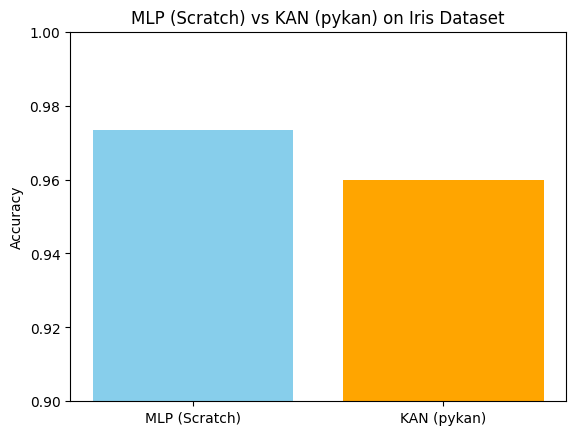

In [124]:
import matplotlib.pyplot as plt

plt.bar(comparison_df["Model"], comparison_df["Mean Test Accuracy"], color=["skyblue", "orange"])
plt.ylim(0.9, 1.0)
plt.ylabel("Accuracy")
plt.title("MLP (Scratch) vs KAN (pykan) on Iris Dataset")
plt.show()
